# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# I opened wireshark and downloaded the pcap as a csv.
# That is why the filename below is different from what you may expect

packets = pd.read_csv("ml-systems-netflix-packets.csv")

In [3]:
packets.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,dest (r),dest(u),src (r),src(u),New Column
0,1,0.000000,192.168.43.72,128.93.77.234,DNS,77,Standard query 0xed0c A fonts.gstatic.com,53.0,53.0,55697.0,55697.0,1
1,2,0.000150,192.168.43.72,128.93.77.234,DNS,77,Standard query 0x301a AAAA fonts.gstatic.com,53.0,53.0,59884.0,59884.0,2
2,3,0.004726,192.168.43.72,128.93.77.234,DNS,87,Standard query 0x11d3 A googleads.g.doubleclic...,53.0,53.0,61223.0,61223.0,3
3,4,0.006522,192.168.43.72,128.93.77.234,DNS,87,Standard query 0x1284 AAAA googleads.g.doublec...,53.0,53.0,58785.0,58785.0,4
4,5,0.011103,192.168.43.72,128.93.77.234,DNS,78,Standard query 0x3432 AAAA ytimg.l.google.com,53.0,53.0,51938.0,51938.0,5
5,6,0.012354,192.168.43.72,128.93.77.234,DNS,96,Standard query 0xb756 A r4---sn-gxo5uxg-jqbe.g...,53.0,53.0,20949.0,20949.0,6
6,7,0.012474,192.168.43.72,128.93.77.234,DNS,75,Standard query 0x62ab A ssl.gstatic.com,53.0,53.0,58025.0,58025.0,7
7,8,0.012567,192.168.43.72,128.93.77.234,DNS,74,Standard query 0x42fb A www.google.com,53.0,53.0,15895.0,15895.0,8
8,9,0.319268,128.93.77.234,192.168.43.72,DNS,386,Standard query response 0x11d3 A 216.58.213.162,61223.0,61223.0,53.0,53.0,9
9,10,0.319288,192.168.43.72,128.93.77.234,DNS,75,Standard query 0x8756 A www.gstatic.com,53.0,53.0,18154.0,18154.0,10


### Cleaning the data frame

Before gettingstarted on the next stemp, I wanted to get a little more familiar with the data. First I wanted to answer:

1. What is the difference between "dest (r)" and "dest(u)"?
2. What is the difference between "src (r)" and "src(u)"?
3. What is going on with the "New Column" column?

I could of course look it up or ask Claude, but where is the fun in that? I wanted to first investigate what is going on myself.

In [4]:
# this cell shows there are 80 instances where "dest (r)" is not equal to "dest(u)"
len(packets) - sum(packets["dest (r)"] == packets["dest(u)"]) 

80

In [5]:
# we investigate what is happening in the cases where these aren't equal
packets[packets["dest (r)"] != packets["dest(u)"]].head(5)

,No.,Time,Source,Destination,Protocol,Length,Info,dest (r),dest(u),src (r),src(u),New Column
877,878,8.391182,CeLink_0d:2b:a7,Apple_01:4c:54,ARP,60,Who has 192.168.43.72? Tell 192.168.43.1,NaN,NaN,NaN,NaN,878
878,879,8.391235,Apple_01:4c:54,CeLink_0d:2b:a7,ARP,42,192.168.43.72 is at e4:ce:8f:01:4c:54,NaN,NaN,NaN,NaN,879
2324,2325,33.085201,fe80::a021:b7ff:febb:19ec,ff02::1,ICMPv6,86,Multicast Listener Query,NaN,NaN,NaN,NaN,2325
2388,2389,34.215829,fe80::e6ce:8fff:fe01:4c54,ff02::1:ff01:4c54,ICMPv6,86,Multicast Listener Report,NaN,NaN,NaN,NaN,2389
2459,2460,35.215949,fe80::e6ce:8fff:fe01:4c54,ff02::1:ff77:3595,ICMPv6,86,Multicast Listener Report,NaN,NaN,NaN,NaN,2460


In [6]:
# we can see that these 80 values are accounted for by NaN values
print(packets[~packets["dest (r)"].isna() & (packets["dest (r)"] != packets["dest(u)"])])

# I used Claude on this cell to debug an issue that I was having with indexing in pandas:
# https://claude.ai/share/d68d6049-2976-400d-9395-e8a6c1cf7f19

Empty DataFrame
Columns: [No., Time, Source, Destination, Protocol, Length, Info, dest (r), dest(u), src (r), src(u), New Column]
Index: []


In [7]:
# we can now show the same thing with "src (r)" and "src(u)"
# we can see that these 80 values are accounted for by NaN values
print(packets[~packets["src (r)"].isna() & (packets["src (r)"] != packets["src(u)"])])

Empty DataFrame
Columns: [No., Time, Source, Destination, Protocol, Length, Info, dest (r), dest(u), src (r), src(u), New Column]
Index: []


In [8]:
# now we investigate the "New Column"
new_col_list = packets["New Column"].to_list()

In [9]:
# now we show that it is just the row number indexed at one
for i in range(len(new_col_list)):
    assert i +1 == new_col_list[i]

So to answer my original questions from above:

1. The values for "dest (r)" and "dest(u)" are always identical
2. The values for "src (r)" and "src(u)" are always identical
3. The values in "New Column" contain no meaningful information.

Therefore we can colapse "dest (r)" and "dest(u)" into a single "dest" column. Likewise, we can colapse "src (r)" and "src(u)" into a single "src" column. We can drop "New Column" entirely.

In [10]:
packets = packets.drop(['src (r)', 'dest (r)', 'New Column'], axis=1)
packets = packets.rename(columns={"dest(u)": "dest", "src(u)": "src"})

# I referenced the link below for how to drop a column in pandas
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

# I referenced the link below to know how to rename columns in pandas
# https://stackoverflow.com/questions/11346283/renaming-column-names-in-pandas

In [11]:
packets.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,dest,src
0,1,0.000000,192.168.43.72,128.93.77.234,DNS,77,Standard query 0xed0c A fonts.gstatic.com,53.0,55697.0
1,2,0.000150,192.168.43.72,128.93.77.234,DNS,77,Standard query 0x301a AAAA fonts.gstatic.com,53.0,59884.0
2,3,0.004726,192.168.43.72,128.93.77.234,DNS,87,Standard query 0x11d3 A googleads.g.doubleclic...,53.0,61223.0
3,4,0.006522,192.168.43.72,128.93.77.234,DNS,87,Standard query 0x1284 AAAA googleads.g.doublec...,53.0,58785.0
4,5,0.011103,192.168.43.72,128.93.77.234,DNS,78,Standard query 0x3432 AAAA ytimg.l.google.com,53.0,51938.0
5,6,0.012354,192.168.43.72,128.93.77.234,DNS,96,Standard query 0xb756 A r4---sn-gxo5uxg-jqbe.g...,53.0,20949.0
6,7,0.012474,192.168.43.72,128.93.77.234,DNS,75,Standard query 0x62ab A ssl.gstatic.com,53.0,58025.0
7,8,0.012567,192.168.43.72,128.93.77.234,DNS,74,Standard query 0x42fb A www.google.com,53.0,15895.0
8,9,0.319268,128.93.77.234,192.168.43.72,DNS,386,Standard query response 0x11d3 A 216.58.213.162,61223.0,53.0
9,10,0.319288,192.168.43.72,128.93.77.234,DNS,75,Standard query 0x8756 A www.gstatic.com,53.0,18154.0


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [12]:
# The variable below is from a previous hands on: https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/03-Performance-Service-Clean.ipynb
NF_DOMAINS = (["nflxvideo", 
              "netflix", 
              "nflxso", 
              "nflxext"])

In [13]:
set(packets['Protocol'])

{'ARP',
 'BOOTP',
 'DNS',
 'EAPOL',
 'HTTP',
 'ICMP',
 'ICMPv6',
 'IGMPv2',
 'MDNS',
 'NBNS',
 'SSLv2',
 'TCP',
 'TLSv1',
 'TLSv1.2'}

In [14]:
# get only DNS packets

dns_packets = packets[packets["Protocol"] == "DNS"]

In [15]:
# I used this chat with claude to learn the syntax for how to iterate over rows
# in a pandas dataframe:
# https://claude.ai/share/323a5fde-d8a8-4104-81cb-f89683cd0d3c

OUR_IP = "192.168.43.72"

netflix_transaction_ids = set()
netflix_ips = set()

for index, row in dns_packets.iterrows():

    # if the packet is a DNS response, see if the response matches any
    # netflix query
    third_word_in_info = row['Info'].split()[2]
    if third_word_in_info == "response":
            transaction_id = row['Info'].split()[3]
            if transaction_id not in netflix_transaction_ids:
                continue
            else:
                netflix_transaction_ids.remove(transaction_id)
            
            netflix_ip = row['Info'].split()[-1]
            
            assert '.' in netflix_ip
            for num in netflix_ip.split('.'):
                int(num) # make sure this doesn't throw an error
            
            netflix_ips.add(netflix_ip)

    # if the packet is a DNS request for netflix, extract and track the
    # transaction id

    for domain in NF_DOMAINS:
        if domain in row['Info']:
            
            transaction_id = row['Info'].split()[2]
        
            assert '0x' in transaction_id
            netflix_transaction_ids.add(transaction_id)
            break

In [16]:
netflix_ips

{'198.38.120.130',
 '198.38.120.134',
 '198.38.120.137',
 '198.38.120.153',
 '198.38.120.162',
 '198.38.120.164',
 '198.38.120.166',
 '198.38.120.167',
 '23.57.80.120',
 '34.252.77.54',
 '52.19.39.146',
 '52.208.128.101',
 '52.210.133.255',
 '52.210.19.176',
 '52.48.148.78',
 '52.48.8.150'}

We have extacted our IP addresses for netflix servers using the DNS traffic. As a sanity check,
lets now inspect the DNS packets that have these IP addresses.

In [17]:
netflix_transaction_ids = []
for index, row in dns_packets.iterrows():
    for ip in netflix_ips:
        if ip in row["Info"]:
            print(row["Info"])
            netflix_transaction_ids.append(row["Info"].split()[3])

Standard query response 0x7776 A 198.38.120.130
Standard query response 0xb19a A 52.19.39.146
Standard query response 0x1f03 A 52.210.19.176
Standard query response 0x37e9 A 198.38.120.153
Standard query response 0x3049 A 23.57.80.120
Standard query response 0x5f60 A 23.57.80.120
Standard query response 0x6677 A 198.38.120.137
Standard query response 0xbe57 A 23.57.80.120
Standard query response 0x9415 A 198.38.120.167
Standard query response 0x5542 A 34.252.77.54
Standard query response 0x269f A 198.38.120.134
Standard query response 0x80e9 A 198.38.120.164
Standard query response 0xc0b4 A 198.38.120.166
Standard query response 0x3981 A 198.38.120.162
Standard query response 0x82dc A 52.48.148.78
Standard query response 0x86ee A 52.48.8.150
Standard query response 0xed3f A 52.208.128.101
Standard query response 0xa9b1 A 52.210.133.255


In [18]:
for index, row in dns_packets.iterrows():
    for id in netflix_transaction_ids:
        if id in row["Info"]:
            print(row["Info"])

Standard query 0xb19a A www.netflix.com
Standard query 0x3049 A assets.nflxext.com
Standard query 0x5f60 A codex.nflxext.com
Standard query 0x1f03 A customerevents.netflix.com
Standard query 0x7776 A ipv4-c001-cdg001-ix.1.oca.nflxvideo.net
Standard query 0x37e9 A ipv4-c024-cdg001-ix.1.oca.nflxvideo.net
Standard query response 0x7776 A 198.38.120.130
Standard query response 0xb19a A 52.19.39.146
Standard query response 0x1f03 A 52.210.19.176
Standard query response 0x37e9 A 198.38.120.153
Standard query response 0x3049 A 23.57.80.120
Standard query response 0x5f60 A 23.57.80.120
Standard query 0x9415 A ipv4-c072-cdg001-ix.1.oca.nflxvideo.net
Standard query 0x6677 A occ-0-56-55.1.nflxso.net
Standard query 0xbe57 A tp-s.nflximg.net
Standard query response 0x6677 A 198.38.120.137
Standard query response 0xbe57 A 23.57.80.120
Standard query response 0x9415 A 198.38.120.167
Standard query 0x5542 A push.prod.netflix.com
Standard query response 0x5542 A 34.252.77.54
Standard query 0x269f A ipv

In [19]:
# I used the following claude chat to figure out how to debug a pandas error
# that I was getting in this cell
# https://claude.ai/share/04435ca0-3f0f-42d6-8369-a475e37aa8e5

only_netflix = packets[packets["Source"].isin(netflix_ips) | packets["Destination"].isin(netflix_ips)]

In [20]:
only_netflix.head(5)

,No.,Time,Source,Destination,Protocol,Length,Info,dest,src
107,108,2.368591,192.168.43.72,198.38.120.130,TCP,78,58451 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58451.0
109,110,2.368637,192.168.43.72,198.38.120.130,TCP,78,58452 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58452.0
110,111,2.368733,192.168.43.72,198.38.120.130,TCP,78,58453 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58453.0
112,113,2.368943,192.168.43.72,52.19.39.146,TCP,78,58454 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58454.0
113,114,2.369006,192.168.43.72,52.19.39.146,TCP,78,58455 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58455.0


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

### Length of packet

I start by investigating the length of the packets.

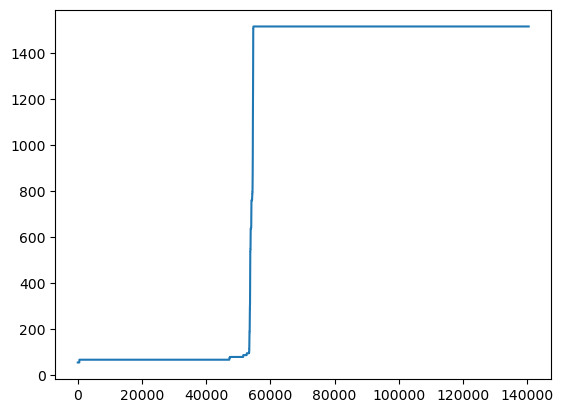

In [21]:
plt.plot(sorted(only_netflix['Length'].tolist()))

The plot above shows that roughly 40% of the packets are far less than 200 bytes while roughtly 60% of packets are greater than 1400 bytes. There is a clear two clusters of packet sizes. Lets break this down in a more granular way:

In [22]:
from_netflix = packets[packets["Source"].isin(netflix_ips) & (packets["Destination"] == OUR_IP)]
from_us = packets[packets["Destination"].isin(netflix_ips) & (packets["Source"] == OUR_IP)]

In [23]:
len(from_netflix), len(from_us)

(87265, 53207)

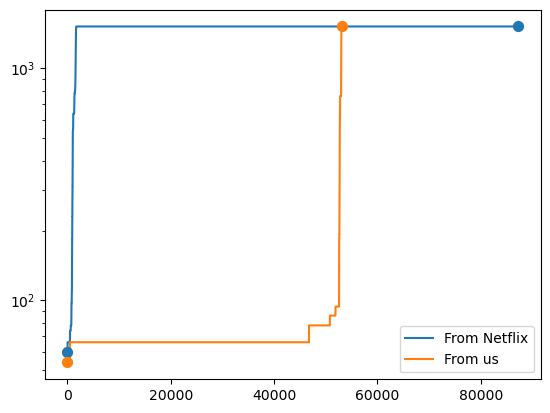

In [24]:
# I used the claude chat below to learn how to set the log axis for matplotlib
# I also used the chat below to learn how to add the dots to the plot to show
# where the lines start and end.
# https://claude.ai/share/30f8441a-91bb-4ee7-b819-9ffd1c4a5a77

netflix_sorted = sorted(from_netflix['Length'].tolist())
us_sorted = sorted(from_us['Length'].tolist())

line1= plt.plot(netflix_sorted, label="From Netflix")
line2 = plt.plot(us_sorted, label="From us")

color1 = line1[0].get_color()
color2 = line2[0].get_color()

plt.scatter([0, len(netflix_sorted)-1], [netflix_sorted[0], netflix_sorted[-1]], 
            color=color1, s=50, zorder=5)
plt.scatter([0, len(us_sorted)-1], [us_sorted[0], us_sorted[-1]], 
            color=color2, s=50, zorder=5)

plt.legend()
plt.yscale('log')

The above shows that almost all of the data from netflix is roughtly 1500s bytes, while almost all the data from us is less than 100 bytes. This means that the size in bytes is heighly correlated with the source or destination IP but the IP doesn't contain all of the relevant information.

### Length of TCP/TLS packets investigation


In [25]:
tcp_from_netflix  = from_netflix[from_netflix["Protocol"]=="TCP"]
tcp_from_us  = from_us[from_us["Protocol"]=="TCP"]
len(tcp_from_netflix), len(tcp_from_us)

(2972, 52605)

In [26]:
TSL_labels = ['TLSv1','TLSv1.2']

tls_from_netflix  = from_netflix[from_netflix["Protocol"].isin(TSL_labels)]
tls_from_us  = from_us[from_us["Protocol"].isin(TSL_labels)]
len(tls_from_netflix), len(tls_from_us)

(84290, 602)

In [27]:
len(from_netflix), len(from_us)

(87265, 53207)

After inspecting the packets in the wireshark and from the simple code above, I have observed the following:

__Observations about TLS packets__
1. The vast majority of packets labeled TLS are from netflix.
2. The vast majority of packets from netlflix are TLS.
3. Almost all TLS packets from netflix have a length of 1514 bytes and contain a TCP payload of 1448 bytes (see below):

<img src='fig1.png'></img>

__Observations about TCP packets__

1. The vast majority of packets labeled TCP are from us (that is, the computer streaming the video).
2. The vast majority of the packets from us are TCP.
3. The TCP packets are more variable in lenght, but tend to be much smaller than the TCP packets described above.



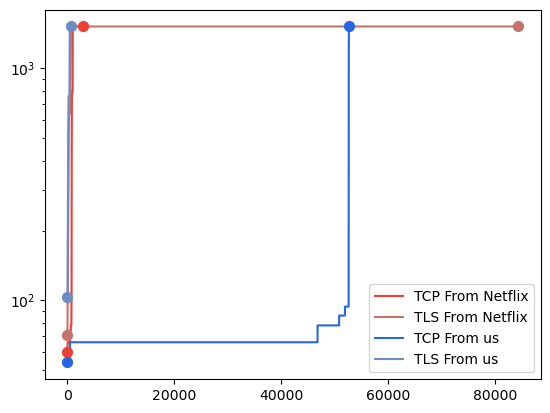

In [28]:
# I used the claude chat below to learn how to set the log axis for matplotlib
# I also used the chat below to learn how to add the dots to the plot to show
# where the lines start and end.
# https://claude.ai/share/30f8441a-91bb-4ee7-b819-9ffd1c4a5a77

netflix_tcp_sorted = sorted(tcp_from_netflix['Length'].tolist())
netflix_tls_sorted = sorted(tls_from_netflix['Length'].tolist())
us_tcp_sorted = sorted(tcp_from_us['Length'].tolist())
us_tls_sorted = sorted(tls_from_us['Length'].tolist())

line1= plt.plot(netflix_tcp_sorted, label="TCP From Netflix", color="#eb4034")
line2 = plt.plot(netflix_tls_sorted, label="TLS From Netflix", color="#c4746e")
line3= plt.plot(us_tcp_sorted, label="TCP From us", color="#2766e3")
line4 = plt.plot(us_tls_sorted, label="TLS From us", color="#6e8bc4")

color1 = line1[0].get_color()
color2 = line2[0].get_color()
color3 = line3[0].get_color()
color4 = line4[0].get_color()

sorted_lengths = [netflix_tcp_sorted, netflix_tls_sorted, us_tcp_sorted, us_tls_sorted]
colors = [color1, color2, color3,color4]

for data, color in zip(sorted_lengths, colors):
    plt.scatter(
        [0, len(data)-1],
        [data[0], data[-1]], 
        color=color, s=50, 
        zorder=5
    )

plt.legend()
plt.yscale('log')

All of this shows us that the video data appears to be coming from netflix in increments of pakcets that are ~1500 bytes. The traffic from us is presumably smaller because all we are doing is setting up a connection with netflix and telling them what we want and confirming we got it (I don't konw much about networking but this is my best guess). This requires a lot less data then sending a whole movie from one server to a client. 

### Encrypted Video Packet Feature

This is a boolean value for if the pakcet is TLS from netflix and contains the full amount of bytes (1514). These packets are almost certainly the ones that actually contain all of the video.

In [29]:
is_encypted_video = only_netflix['Protocol'].isin(TSL_labels) & (only_netflix["Length"] == 1514)

In [30]:
only_netflix['is_encypted_video'] = is_encypted_video

/var/folders/tz/tjkc1y6s6z13lfjrq0gcrjnr0000gn/T/ipykernel_19247/2924783260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_netflix['is_encypted_video'] = is_encypted_video


In [31]:
only_netflix[only_netflix["Length"] == 1514]

,No.,Time,Source,Destination,Protocol,Length,Info,dest,src,is_encypted_video
328,329,4.180597,198.38.120.130,192.168.43.72,TLSv1.2,1514,Server Hello,58453.0,443.0,True
329,330,4.210863,198.38.120.130,192.168.43.72,TLSv1.2,1514,[Packet size limited during capture],58453.0,443.0,True
335,336,4.259119,198.38.120.130,192.168.43.72,TLSv1.2,1514,Server Hello,58451.0,443.0,True
337,338,4.290590,198.38.120.130,192.168.43.72,TLSv1.2,1514,[Packet size limited during capture],58451.0,443.0,True
343,344,4.340149,198.38.120.130,192.168.43.72,TLSv1.2,1514,Server Hello,58452.0,443.0,True
...,...,...,...,...,...,...,...,...,...,...
141185,141186,491.547358,192.168.43.72,52.208.128.101,TLSv1.2,1514,NaN,443.0,58518.0,True
141186,141187,491.547359,192.168.43.72,52.208.128.101,TLSv1.2,1514,[Packet size limited during capture],443.0,58518.0,True
141204,141205,491.607712,198.38.120.164,192.168.43.72,TLSv1.2,1514,[Packet size limited during capture],58520.0,443.0,True
141206,141207,491.609363,198.38.120.164,192.168.43.72,TLSv1.2,1514,[Packet size limited during capture],58520.0,443.0,True


### Splitting data into flows

In [32]:
only_netflix.head(3)

,No.,Time,Source,Destination,Protocol,Length,Info,dest,src,is_encypted_video
107,108,2.368591,192.168.43.72,198.38.120.130,TCP,78,58451 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58451.0,False
109,110,2.368637,192.168.43.72,198.38.120.130,TCP,78,58452 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58452.0,False
110,111,2.368733,192.168.43.72,198.38.120.130,TCP,78,58453 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58453.0,False


In [33]:
# we separate the dataframe into TCP packets for each ip from netflix
# our computer is in communication with
netflix_ip_to_packet_dataframe = dict()

for ip in netflix_ips:
    flow_df = packets[(packets["Source"] == ip) | (packets["Destination"] == ip)] 
    netflix_ip_to_packet_dataframe[ip] = flow_df


In [34]:
for ip_name, dataframe in netflix_ip_to_packet_dataframe.items():
    print(f"{ip_name} --> {len(dataframe)}")

52.19.39.146 --> 961
198.38.120.162 --> 604
52.208.128.101 --> 191
198.38.120.130 --> 73
198.38.120.164 --> 8043
198.38.120.153 --> 138
34.252.77.54 --> 46
52.48.8.150 --> 0
52.210.133.255 --> 0
198.38.120.134 --> 121
198.38.120.166 --> 127986
198.38.120.137 --> 190
52.48.148.78 --> 35
23.57.80.120 --> 1839
52.210.19.176 --> 126
198.38.120.167 --> 119


This tells us that the vast majority of netflix data goes through a single flow. Now lets assign a number to each flow and label them in the dataframe.

In [35]:
netflix_ip_to_flow = {ip: i for i, ip in enumerate(netflix_ips)}
flow_feature = []

for index, row in only_netflix.iterrows():
    source, dest = row["Source"], row["Destination"]

    feature_val = -1
    for ip in netflix_ips:
        if ip == source or ip == dest:
            feature_val = netflix_ip_to_flow[ip]
            break

    flow_feature.append(feature_val)
        

In [36]:
only_netflix["flow_num"] = flow_feature

/var/folders/tz/tjkc1y6s6z13lfjrq0gcrjnr0000gn/T/ipykernel_19247/2171941691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_netflix["flow_num"] = flow_feature


In [37]:
only_netflix.head(5)

,No.,Time,Source,Destination,Protocol,Length,Info,dest,src,is_encypted_video,flow_num
107,108,2.368591,192.168.43.72,198.38.120.130,TCP,78,58451 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58451.0,False,3
109,110,2.368637,192.168.43.72,198.38.120.130,TCP,78,58452 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58452.0,False,3
110,111,2.368733,192.168.43.72,198.38.120.130,TCP,78,58453 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58453.0,False,3
112,113,2.368943,192.168.43.72,52.19.39.146,TCP,78,58454 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58454.0,False,0
113,114,2.369006,192.168.43.72,52.19.39.146,TCP,78,58455 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58455.0,False,0


### Packet number in flow

If we would like to feed a packet into some kind of neural network, we may be interested in how far it is into a flow. If we would like to make some kind of positional encoding later, this kind of information would also be useful.

In [38]:
flow_idx = {netflix_ip_to_flow[ip]: 0 for ip in netflix_ips}
flow_idx_feature_list = []

for index, row in only_netflix.iterrows():
    source, dest = row["Source"], row["Destination"]

    feature_val = -1
    for ip in netflix_ips:
        if ip == source or ip == dest:
            feature_val = netflix_ip_to_flow[ip]
            break

    flow_idx_feature_list.append(flow_idx[feature_val])
    flow_idx[feature_val] += 1


In [39]:
only_netflix["flow_index"] = flow_idx_feature_list

/var/folders/tz/tjkc1y6s6z13lfjrq0gcrjnr0000gn/T/ipykernel_19247/1608043422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_netflix["flow_index"] = flow_idx_feature_list


In [40]:
only_netflix.head(6)

,No.,Time,Source,Destination,Protocol,Length,Info,dest,src,is_encypted_video,flow_num,flow_index
107,108,2.368591,192.168.43.72,198.38.120.130,TCP,78,58451 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58451.0,False,3,0
109,110,2.368637,192.168.43.72,198.38.120.130,TCP,78,58452 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58452.0,False,3,1
110,111,2.368733,192.168.43.72,198.38.120.130,TCP,78,58453 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58453.0,False,3,2
112,113,2.368943,192.168.43.72,52.19.39.146,TCP,78,58454 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58454.0,False,0,0
113,114,2.369006,192.168.43.72,52.19.39.146,TCP,78,58455 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58455.0,False,0,1
114,115,2.369087,192.168.43.72,52.19.39.146,TCP,78,58456 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58456.0,False,0,2


**Write a brief justification for the features that you have chosen.**

I wrote breif justifications in markdown by the relevant code above.

In [41]:
set(packets["Protocol"])

{'ARP',
 'BOOTP',
 'DNS',
 'EAPOL',
 'HTTP',
 'ICMP',
 'ICMPv6',
 'IGMPv2',
 'MDNS',
 'NBNS',
 'SSLv2',
 'TCP',
 'TLSv1',
 'TLSv1.2'}

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [42]:
min(only_netflix['Time']), max(only_netflix["Time"])

(2.368591, 495.76445)

In [43]:
segments = []
current_burst = [] # we track the idxs for each burst to construct segments
last_time = -1


i_in_only_net= 0
for _, row in only_netflix.iterrows():
    # print(index)
    current_time = row['Time']
    if last_time != -1 and abs(current_time -last_time) >= 0.1:
        segments.append(current_burst)
        current_burst = [i_in_only_net]
    else:
        current_burst.append(i_in_only_net)
    
    last_time = current_time
    i_in_only_net += 1

In [44]:
len(only_netflix)

140472

In [45]:
sdr_col = np.zeros((1, len(only_netflix)))
net_times = list(only_netflix['Time'])

for s in segments:
    segment_start = net_times[s[0]]
    try:
        segment_end = net_times[s[-1]]
    except:
        segment_end = net_times[s[0]]

    sdr = 1 / ((segment_end - segment_start) + 1e-5)
    sdr_col[:,s] = sdr

In [46]:
only_netflix['segment_download_rate'] = sdr_col[0]

/var/folders/tz/tjkc1y6s6z13lfjrq0gcrjnr0000gn/T/ipykernel_19247/3299427818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_netflix['segment_download_rate'] = sdr_col[0]


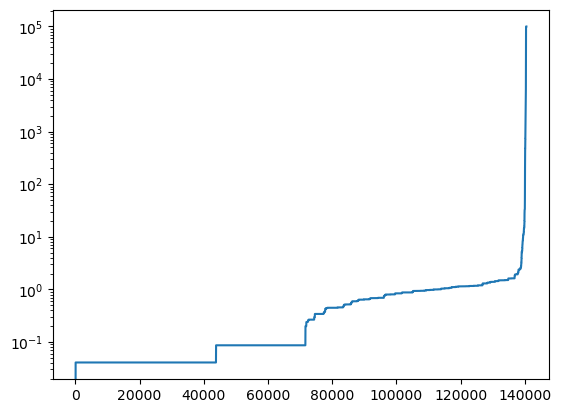

In [47]:
plt.plot(sorted(list(only_netflix['segment_download_rate'])))
plt.yscale('log')

In [48]:
only_netflix.head(7)

,No.,Time,Source,Destination,Protocol,Length,Info,dest,src,is_encypted_video,flow_num,flow_index,segment_download_rate
107,108,2.368591,192.168.43.72,198.38.120.130,TCP,78,58451 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58451.0,False,3,0,473.036897
109,110,2.368637,192.168.43.72,198.38.120.130,TCP,78,58452 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58452.0,False,3,1,473.036897
110,111,2.368733,192.168.43.72,198.38.120.130,TCP,78,58453 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58453.0,False,3,2,473.036897
112,113,2.368943,192.168.43.72,52.19.39.146,TCP,78,58454 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58454.0,False,0,0,473.036897
113,114,2.369006,192.168.43.72,52.19.39.146,TCP,78,58455 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58455.0,False,0,1,473.036897
114,115,2.369087,192.168.43.72,52.19.39.146,TCP,78,58456 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58456.0,False,0,2,473.036897
115,116,2.369131,192.168.43.72,52.19.39.146,TCP,78,58457 > 443 [SYN] Seq=0 Win=65535 Len=0 MSS=...,443.0,58457.0,False,0,3,473.036897


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [49]:
# I used the below link to refresh my memory for the correct syntax of opening a file with pickle
# https://stackoverflow.com/questions/35067957/how-to-read-pickle-file

import pickle

with open("netflix_dataset.pkl", "rb") as f:
    video_packets = pickle.load(f)

/var/folders/tz/tjkc1y6s6z13lfjrq0gcrjnr0000gn/T/ipykernel_19247/275386978.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  video_packets = pickle.load(f)


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [50]:
VALID_RESOLUTIONS = [240.0, 360.0, 480.0, 7280.0, 1080.0]

In [51]:
video_packets = video_packets[video_packets['resolution'].isin(VALID_RESOLUTIONS)]

In [52]:
video_packets.head()

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

I first observed that there are some columns where all the values are identical.

In [53]:
print(f"{sum(video_packets['service'] != 'netflix')} rows where 'service' != 'netflix'")

0 rows where 'service' != 'netflix'


In [54]:
print(f"{sum(video_packets['ads'])} rows where 'ads' is True")

0 rows where 'ads' is True


I choose to remove these in an automated way.

In [55]:
# identify cols where all the values are identical

cols_all_vals_identical = []

for col in list(video_packets.columns):
    first_val = list(video_packets[col])[0]
    try:
        num_neq_first = sum(video_packets[col] != first_val)
        if num_neq_first <= 10:
            cols_all_vals_identical.append(col)
    except:
        print("could not compute equality for col:", col)

could not compute equality for col: 10_EWMA_chunksizes


In [56]:
(max(video_packets["absolute_timestamp"]) - min(video_packets["absolute_timestamp"])) / max(video_packets["absolute_timestamp"]) 

0.022597737868972748

In [57]:
handpicked_to_drop = ['absolute_timestamp', 'session_id', 'size_diff_previous', 'video_id', 'home_id', 'deployment_session_id', '10_EWMA_chunksizes']
DROP = list(set(handpicked_to_drop + cols_all_vals_identical))
video_packets = video_packets.drop(DROP, axis=1)

**Briefly explain why you removed those columns.**

There are 14 columns where all the values are exactly equal. However, there are 3 more columns where less than three rows have a value that differs from the value of the first row in the packet trace. Therefore, we drop 17 total rows for having columns where all the values have practically the same contents regardless of the row.

For "session_id", this is a string that would probably not ever be identically to anything in the training data if you ran inference of the model in a new session. For the same reason, we drop 'video_id', "deployment_session_id", and "home_id".

I also drop '10_EWMA_chunksizes' because it is not a scalar or a boolean.

We drop absolute_timestamp becuase even if it was normalized, the actual value of this would probably not be correlated with anything too meaningful. It looks like all these videos were recorded at roughly the same time in the day so there isn't really meaningful temporal information here. To demonstrate, the code below would evaluate to 0.0225977...

```python
(max(video_packets["absolute_timestamp"]) - min(video_packets["absolute_timestamp"])) / max(video_packets["absolute_timestamp"])
```

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

The extent of my preparation is normalize each row such that it's standard deviation is 1 and it mean is 0.

In [58]:
# I used the second query on this chat for the syntax for switching a column of two
# strings to booleans
# https://claude.ai/share/60351edd-b69f-4ec4-819e-ba1a65ebda63
video_packets['quality'] = (video_packets['quality'] == 'good').astype(int)

In [59]:
# I used the first query in this chat for the syntax to normalize each row by mean and standard deviation
# https://claude.ai/share/60351edd-b69f-4ec4-819e-ba1a65ebda63
video_packets_normalized = (video_packets - video_packets.mean()) / video_packets.std()

In [60]:
video_packets_normalized

,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,10_max_chunksize,...,userStrBytesInFlight,userSynFlags,userTwoRetransmit,userXRetransmit,userZeroRetransmit,startup3.3,startup6.6,startup5,startup10,startup_mc
208,-0.946509,-1.064809,-1.064809,-0.907883,-0.907883,-0.720511,-0.720511,-0.625105,-0.625105,-0.568659,...,-0.186454,2.171929,-0.121388,0.372187,2.896016,-0.62654,-1.484073,-1.087140,-3.302431,1.777518
209,-1.045167,-0.976011,-0.976011,-0.987554,-0.987554,-0.956314,-0.956314,-0.935483,-0.935483,-0.889314,...,-0.186454,0.397315,-0.121388,0.494824,2.837036,-0.62654,-1.484073,-1.087140,-3.302431,1.777518
210,-0.948626,-0.961582,-0.961582,-0.858310,-0.858310,-0.808711,-0.808711,-0.774952,-0.774952,-0.702379,...,-0.186454,-0.194224,-0.121388,0.645379,2.764629,-0.62654,-1.484073,-1.087140,-3.302431,1.777518
211,-0.777688,-0.678583,-0.678583,-0.723042,-0.723042,-0.721447,-0.721447,-0.716697,-0.716697,-0.702379,...,-0.186454,0.397315,-0.121388,1.538740,2.334987,-0.62654,-1.484073,-1.087140,-3.302431,1.777518
212,-0.621359,-0.592020,-0.592020,-0.635493,-0.635493,-0.664437,-0.664437,-0.677177,-0.677177,-0.663875,...,-0.186454,-0.194224,-0.121388,1.664369,2.274568,-0.62654,-1.484073,-1.087140,-3.302431,1.777518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200633,-0.341460,-0.275407,-0.275407,-0.397062,-0.397062,-0.440994,-0.440994,-0.453229,-0.453229,-0.427997,...,-0.186454,-0.194224,-0.121388,-0.848207,-0.746356,-0.62654,0.673805,0.919822,0.302800,-0.405341
200634,-0.345973,-0.301083,-0.301083,-0.397062,-0.397062,-0.435134,-0.435134,-0.445526,-0.445526,-0.427997,...,-0.186454,-0.194224,-0.121388,-0.324754,-0.393915,-0.62654,0.673805,0.919822,0.302800,-0.405341
200635,-0.236377,-0.285675,-0.285675,-0.290320,-0.290320,-0.290440,-0.290440,-0.273160,-0.273160,-0.119453,...,-0.186454,-0.194224,-0.121388,-0.848207,-0.746356,-0.62654,0.673805,0.919822,0.302800,-0.405341
200636,-0.166741,-0.242744,-0.242744,-0.197671,-0.197671,-0.131713,-0.131713,-0.097419,-0.097419,-0.119453,...,-0.186454,-0.194224,-0.121388,-0.324754,-0.393915,-0.62654,0.673805,0.919822,0.302800,-0.405341


In [61]:
# we have to drop the labels from the training data
video_packets_normalized = video_packets_normalized.drop("resolution", axis=1)

In [62]:
import torch

In [63]:
resolutions = list(set(video_packets['resolution']))
resolution_to_class = {r:i for i, r in enumerate(resolutions)}
resolution_to_class

{360.0: 0, 480.0: 1, 1080.0: 2, 240.0: 3}

In [64]:
labels = []
for r in video_packets['resolution']:
    labels.append(resolution_to_class[r])
labels = torch.tensor(labels)

In [65]:
# I used this link to understand how to turn a pandas dataframe into a torch tensor
dataset = torch.tensor(video_packets_normalized.values)

In [66]:
torch.sum(torch.isnan(dataset))/dataset.numel()

tensor(0.0002)

In [67]:
# I chose to replace nan values with 0 because there are so few of 
# them they are basically just noise

dataset[torch.isnan(dataset)] = 1

In [68]:
cutoff1 = int(len(dataset) * 0.8)
cutoff2 = int(len(dataset) * 0.9)

train = dataset[0:cutoff1].float()
val = dataset[cutoff1: cutoff2].float()
test = dataset[cutoff2:].float()

trainy = labels[0:cutoff1]
valy = labels[cutoff1: cutoff2]
testy = labels[cutoff2:]

In [69]:
train.shape, val.shape, test.shape

(torch.Size([32232, 227]), torch.Size([4029, 227]), torch.Size([4030, 227]))

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [70]:
import torch
from torch import nn

hidden_layer_size = 20
input_dim = train.shape[1]

# I used this link for a basic refressure on pytorch syntax
# https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

class ResolutionPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(227, 16)
        self.layer2 = nn.Linear(16, 4)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        assert x.shape[1] == input_dim

        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)

        return out

model = ResolutionPredictor()

In [71]:
def get_batch(dataset, batch_size):
    dataset_str_to_tensor = {
        'train': (train, trainy),
        'val': (val, valy),
        'test': (test, testy)
    }

    data, datay = dataset_str_to_tensor[dataset]

    # I used this claude link for a refresher on how to sample random
    # integers in pytorch
    # https://claude.ai/share/3c1ac438-7f14-4a41-83de-bd0105fcd02e
    idxs = torch.randint(0, len(data), (batch_size,))    
    
    return data[idxs,:], datay[idxs]

In [72]:
loss_fn = torch.nn.CrossEntropyLoss()

In [73]:
def get_validation_loss_acc(model):
    with torch.no_grad():
        pred = model(val)
        loss = loss_fn(pred, valy)
        # print(len(pred))
        acc = sum(torch.argmax(pred, dim=1) == valy) / len(pred)
        # print(loss, acc)
        return loss, acc

In [74]:
batch_size = 16

adam = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

def train_model(num_batches):
    dataset = 'train'

    losses = []
    curr_loss_sum = torch.tensor(0.0)
    avg_losses_per_1000_batches = []
    print_every = 1000

    val_losses = []
    
    for i in range(num_batches):
        batch,ys = get_batch(dataset, batch_size)
        pred = model(batch)
        loss = loss_fn(pred, ys)
        loss.backward()
        adam.step()
        adam.zero_grad()

        losses.append(loss.item())
        curr_loss_sum += loss.item()
        
        if i != 0 and i % print_every == 0:
            avg_loss = curr_loss_sum.item() / print_every
            print(curr_loss_sum / print_every)
            curr_loss_sum = torch.tensor(0.0)
            avg_losses_per_1000_batches.append(avg_loss)

            val_loss, _ = get_validation_loss_acc(model)
            val_losses.append(val_loss.item())
    return losses, avg_losses_per_1000_batches, val_losses

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [75]:
decays_to_try = [1e-2, 1e-3, 1e-4, 1e-5]
lr_to_try = [1e-2, 1e-3, 1e-4]

acc_vals = torch.zeros((len(lr_to_try), len(decays_to_try)))

for i, lr in enumerate(lr_to_try):
    for j, decay in enumerate(decays_to_try):
        model = ResolutionPredictor()
        adam = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)


        train_model(len(train) * 2)
        loss, acc = get_validation_loss_acc(model)
        acc_vals[i][j] = acc.item()
        

tensor(0.3363)
tensor(0.3086)
tensor(0.3049)
tensor(0.3156)
tensor(0.3073)
tensor(0.3224)
tensor(0.3106)
tensor(0.3165)
tensor(0.3102)
tensor(0.3179)
tensor(0.3150)
tensor(0.3179)
tensor(0.3096)
tensor(0.3094)
tensor(0.3260)
tensor(0.3159)
tensor(0.3115)
tensor(0.2959)
tensor(0.3139)
tensor(0.3140)
tensor(0.3032)
tensor(0.3141)
tensor(0.3130)
tensor(0.2994)
tensor(0.3128)
tensor(0.3121)
tensor(0.3191)
tensor(0.3109)
tensor(0.3059)
tensor(0.3128)
tensor(0.3107)
tensor(0.3081)
tensor(0.3062)
tensor(0.3155)
tensor(0.3071)
tensor(0.3131)
tensor(0.3019)
tensor(0.3078)
tensor(0.3142)
tensor(0.3103)
tensor(0.3052)
tensor(0.3128)
tensor(0.3047)
tensor(0.3212)
tensor(0.3182)
tensor(0.3115)
tensor(0.3115)
tensor(0.3173)
tensor(0.3330)
tensor(0.3187)
tensor(0.3073)
tensor(0.3108)
tensor(0.2983)
tensor(0.3057)
tensor(0.3029)
tensor(0.3124)
tensor(0.3042)
tensor(0.3114)
tensor(0.3199)
tensor(0.3029)
tensor(0.3114)
tensor(0.3138)
tensor(0.3159)
tensor(0.3030)
tensor(0.3188)
tensor(0.2740)
tensor(0.2

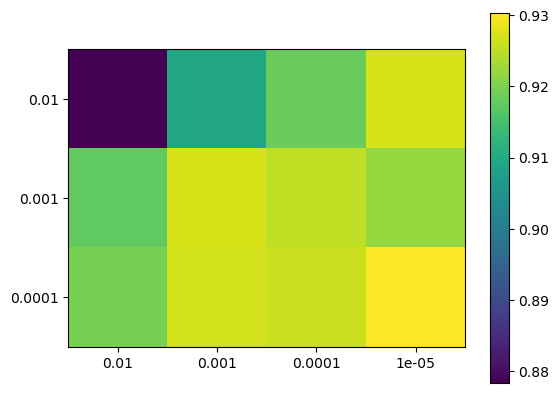

In [76]:
# I used this chat to learn how to add the labels to this plot
# https://claude.ai/share/eefee900-839c-40f2-b467-343d2d84c99e

plt.imshow(acc_vals)
plt.yticks([0, 1, 2], lr_to_try)
plt.xticks([0, 1, 2, 3], decays_to_try)
plt.colorbar()
plt.show()

The above shows us that we should use low weight decay and low learning rate. To train our final model we use a weight decay of 1e-4 and a learning rate of 1e-4.

In [77]:
model = ResolutionPredictor()
adam = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
losses, avg_losses, val_losses = train_model(len(train) * 3)

tensor(0.9872)
tensor(0.4450)
tensor(0.3399)
tensor(0.2987)
tensor(0.2798)
tensor(0.2720)
tensor(0.2552)
tensor(0.2519)
tensor(0.2545)
tensor(0.2344)
tensor(0.2341)
tensor(0.2345)
tensor(0.2186)
tensor(0.2227)
tensor(0.2190)
tensor(0.2167)
tensor(0.2207)
tensor(0.2207)
tensor(0.2119)
tensor(0.1973)
tensor(0.2032)
tensor(0.2081)
tensor(0.2096)
tensor(0.1960)
tensor(0.2051)
tensor(0.2025)
tensor(0.1887)
tensor(0.1996)
tensor(0.1916)
tensor(0.1929)
tensor(0.1911)
tensor(0.1882)
tensor(0.1804)
tensor(0.1858)
tensor(0.1874)
tensor(0.1743)
tensor(0.1804)
tensor(0.1765)
tensor(0.1832)
tensor(0.1730)
tensor(0.1797)
tensor(0.1756)
tensor(0.1758)
tensor(0.1743)
tensor(0.1753)
tensor(0.1677)
tensor(0.1714)
tensor(0.1746)
tensor(0.1689)
tensor(0.1755)
tensor(0.1718)
tensor(0.1691)
tensor(0.1686)
tensor(0.1633)
tensor(0.1646)
tensor(0.1671)
tensor(0.1648)
tensor(0.1620)
tensor(0.1611)
tensor(0.1582)
tensor(0.1644)
tensor(0.1603)
tensor(0.1694)
tensor(0.1620)
tensor(0.1571)
tensor(0.1569)
tensor(0.1

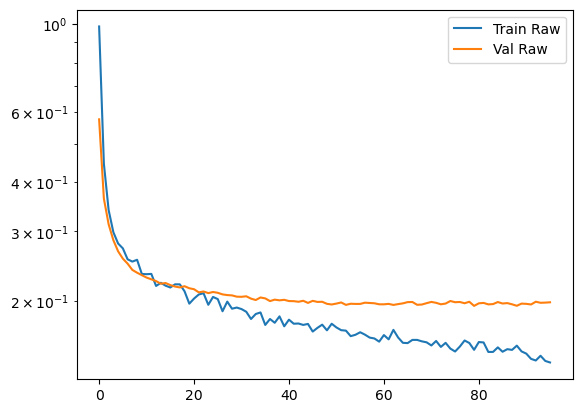

In [78]:
# I used this chat to help make this plot a little easier to look at (added smoothed line for loss)
# https://claude.ai/share/c46afa5d-0cde-4fae-b915-9324ddc56b23
# modified claudes code quite a bit to get the result below

import numpy as np

window_size = 20
# smoothed_losses = np.convolve(avg_losses, np.ones(window_size)/window_size, mode='valid')
# smoothed_val_losses = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')


# Plot both lines
plt.plot(avg_losses, label='Train Raw')
plt.plot(val_losses, label='Val Raw')
# plt.plot(range(window_size-1, len(avg_losses)), smoothed_losses, label='Train Smoothed')
# plt.plot(range(window_size-1, len(val_losses)), smoothed_val_losses, label='Val Smoothed')

plt.yscale('log')
plt.legend()
plt.show()

In [79]:
get_validation_loss_acc(model)

(tensor(0.1981), tensor(0.9248))

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [80]:
def get_test_acc(model):
    with torch.no_grad():
        pred = model(test)
        loss = loss_fn(test, testy)
        # print(len(pred))
        acc = sum(torch.argmax(pred, dim=1) == testy) / len(pred)
        # print(loss, acc)
        return loss, acc

In [81]:
get_test_acc(model)

(tensor(6.6162), tensor(0.9352))

__Accuracy:__ 93.7%

In [82]:
# for each class we print the F1 score
# I used this link to understand how to calculate F1
# https://www.geeksforgeeks.org/machine-learning/f1-score-in-machine-learning/

for res, c in resolution_to_class.items():
    pred = model(test)
    mask = torch.argmax(pred, dim=1) == c
    all_positives = sum(mask)
    true_positives = sum(mask & (testy == c))
    print(f'F1 Score for resolution {res}:  \t{(true_positives / all_positives).item()*100:.4f}')
    # pred_classes = torch.argmax(pred, dim=1) == testy)

F1 Score for resolution 360.0:  	78.4053
F1 Score for resolution 480.0:  	95.6841
F1 Score for resolution 1080.0:  	99.7912
F1 Score for resolution 240.0:  	50.8197


In [83]:
resolution_to_class

{360.0: 0, 480.0: 1, 1080.0: 2, 240.0: 3}

In [84]:
# confusion matrix
# I used this link to understand what a confusion matrix is: 
# https://www.geeksforgeeks.org/machine-learning/confusion-matrix-machine-learning/

print("\t|", end="")

for r, _ in resolution_to_class.items():
    print(f'{int(r)}\t|', end="")
print()
print('-'* 41)


for res, c in resolution_to_class.items():
    pred = model(test)
    mask = testy == c
    test_class = test[mask]
    # print(test.shape, test_class.shape)
    print(f'{int(res)}\t|', end="")

    pred = model(test_class)
    classes = torch.argmax(pred, dim=1)
    for c in resolution_to_class.values():
        print(f"{torch.sum(classes == c)}", end="\t|")
    print()
    

	|360	|480	|1080	|240	|
-----------------------------------------
360	|236	|87	|0	|35	|
480	|47	|2993	|1	|25	|
1080	|0	|4	|478	|0	|
240	|18	|44	|0	|62	|


In [85]:
# ROC/AUC

tps = []
fps = []

def get_roc_auc(curr_class):
    tps = []
    fps = []
    
    for s in torch.arange(-1, 1.01, 0.01):
        pred = model(test)
        pred = torch.nn.functional.softmax(pred, dim=1)
        pred[:,curr_class] += s.item()
    
        true_positive = sum((torch.argmax(pred, dim=1) == curr_class) & (testy == curr_class))
        false_positive = sum((torch.argmax(pred, dim=1) == curr_class) & (testy != curr_class))
        all_positives = true_positive + false_positive
    
        tps.append(true_positive / sum(testy == curr_class))
        fps.append(false_positive / sum(testy != curr_class))

    return tps, fps

In [86]:
class_to_res = {c: int(r) for r, c in resolution_to_class.items()}

Text(0.5, 1.0, 'curve for 360')

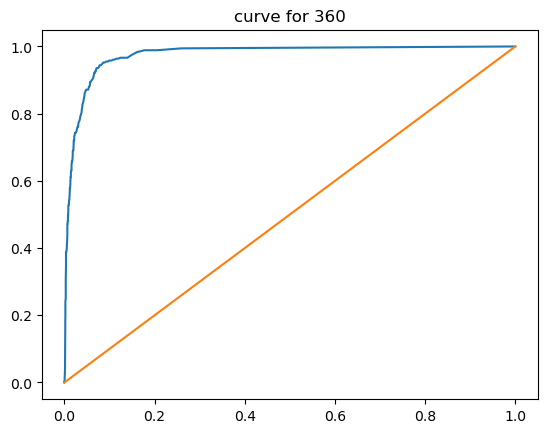

In [87]:
c = 0
tps, fps = get_roc_auc(c)
plt.plot(fps, tps)
plt.plot(torch.arange(0, 1.01, 0.01), torch.arange(0, 1.01, 0.01))
plt.title(f"curve for {class_to_res[c]}")

Text(0.5, 1.0, 'curve for 480')

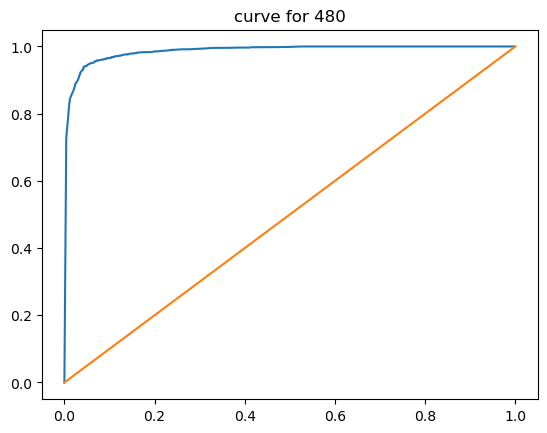

In [88]:
c = 1
tps, fps = get_roc_auc(c)
plt.plot(fps, tps)
plt.plot(torch.arange(0, 1.01, 0.01), torch.arange(0, 1.01, 0.01))
plt.title(f"curve for {class_to_res[c]}")

Text(0.5, 1.0, 'curve for 1080')

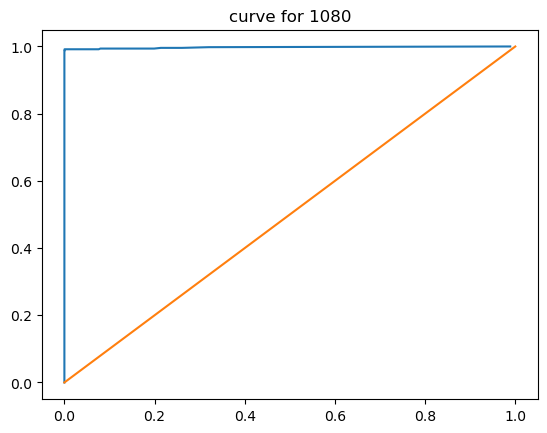

In [89]:
c = 2
tps, fps = get_roc_auc(c)
plt.plot(fps, tps)
plt.plot(torch.arange(0, 1.01, 0.01), torch.arange(0, 1.01, 0.01))
plt.title(f"curve for {class_to_res[c]}")

Text(0.5, 1.0, 'curve for 240')

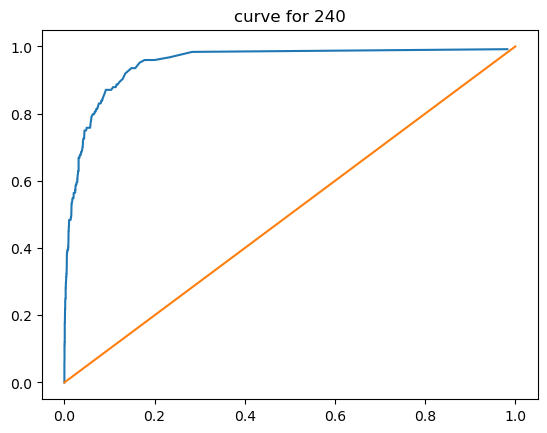

In [90]:
c = 3
tps, fps = get_roc_auc(c)
plt.plot(fps, tps)
plt.plot(torch.arange(0, 1.01, 0.01), torch.arange(0, 1.01, 0.01))
plt.title(f"curve for {class_to_res[c]}")

### Reflection

All of these statistics seem to indicate that we have an exceptionally strong model!

* The total accuracy is 93.7% which is much higher than random guessing (which would be 25%).
* The F1 scores all look extremely solid other than the 52% for resolution 240. This means that there are quite a few false positives for this resolution.
* The confusion matrix does not indicate anything too alarming outside of the false positives for 240 as described above.
* This confusion matrix reveals that there are no false positives for resolution 1080. Likewise, there are also almost zero false negatives for 1080. This indicates that there is likely something in our data that is extremely predictive of the 1080 resolution.
* The ROC/AUC curves were gen

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [91]:
unnormalized_test_set = torch.tensor(np.array(video_packets.values, dtype=np.float32))[cutoff2:]

In [95]:
timestamp_index = list(video_packets.columns).index("relative_timestamp")

In [96]:
unnormalized_test_set[:, timestamp_index]

tensor([120., 130., 140.,  ..., 580., 590., 600.])

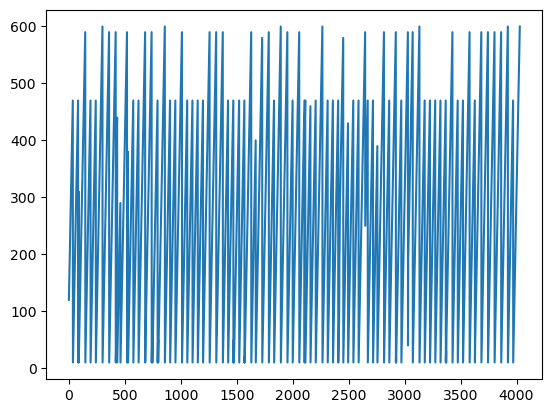

In [97]:
plt.plot(unnormalized_test_set[:, timestamp_index])

In [98]:
torch.min(torch.abs(unnormalized_test_set[1:, timestamp_index] - unnormalized_test_set[:-1, timestamp_index]))

tensor(10.)

It looks like the data is recorded such that everything belongs to an interval of 10s. Sometimes the things aren't separated perfectly, but at the very least there should be a 10 second gap. Therefore, we can simply complete this task by showing the model's prediction for each item in the test set.

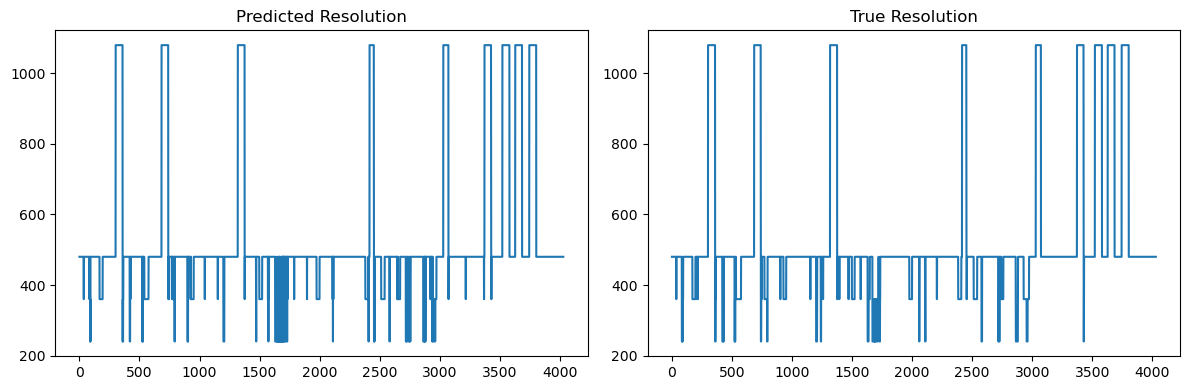

In [99]:
# I used this claude chat to understand how to make the plots side by side.
# This was necessary because it is hard to see the results when the lines overlap so much
# https://claude.ai/share/5eb43339-a66c-4e18-9c9b-bd0131b9da0c

pred = model(test)
classes = torch.argmax(pred, dim=1)
pred_res = [class_to_res[c.item()] for c in classes]
true_res = [class_to_res[c.item()] for c in testy]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(pred_res)
plt.title("Predicted Resolution")

plt.subplot(1, 2, 2)
plt.plot(true_res)
plt.title("True Resolution")

plt.tight_layout()
plt.show()